In [1]:
import numpy as np
import ROOT as rt
import os, glob

import matplotlib.pyplot as plt
%matplotlib notebook
# plt.style.use('olmo')

# from histo_utilities import create_TH1D
from cebefo_style import cebefo_style
cebefo_style()

c_light = 2.99792458E8 #m/s
!pwd
os.chdir('/Users/olmo/programs/Delphes')
!pwd

rt.gSystem.Load("libDelphes")
rt.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
rt.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')

Welcome to JupyROOT 6.12/06
/Users/olmo/cernbox/PID_timing_studies/plot_script
/Users/olmo/programs/Delphes


True

In [2]:
file_path = glob.glob('/Users/olmo/cernbox/PID_timing_studies/_root/jobs_PU140_delta_fulltree/pp2RHad_M500/*.root')

chain = rt.TChain('Delphes')
for path in file_path:
    chain.Add(path)
    
# chain.Print()

treeReader = rt.ExRootTreeReader(chain)
numberOfEntries = treeReader.GetEntries()

print numberOfEntries, 'events found'

branches_names = ['Event', 'Particle', 'Track','Vertex4D', 'GenVertex']
branch = {}

for b in branches_names:
    branch[b] = treeReader.UseBranch(b)

10000 events found


In [3]:
beta_list = []
eta_list = []

for i in range(int(numberOfEntries*1.)):
    treeReader.ReadEntry(i)
    
    for j in range(branch['Track'].GetEntries()):
        track = branch['Track'].At(j)
        p = track.Particle.GetObject()
            
        if abs(p.PID) > 500000:
            beta_list.append(p.P/p.E)
            eta_list.append(p.Eta)            

Warning in <TROOT::Append>: Replacing existing TH1: h_beta (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


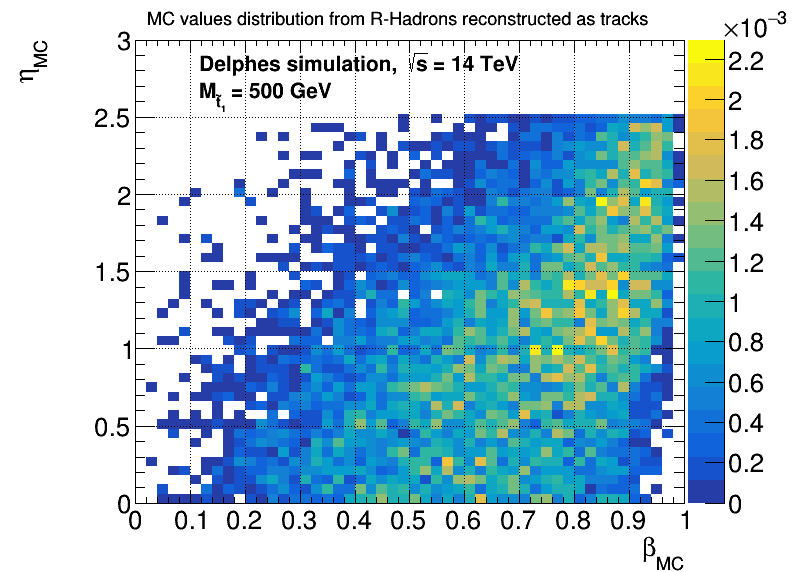

In [8]:
h_2D = rt.TH2F('h_beta','h_beta', 50, 0, 1, 50, 0, 3)
h_2D.SetXTitle('#beta_{MC}')
h_2D.SetYTitle('#eta_{MC}')
h_2D.SetZTitle('#frac{1}{#sigma} #frac{d#sigma}{d#beta_{MC}}')
h_2D.SetTitle('MC values distribution from R-Hadrons reconstructed as tracks')
h_2D.SetStats(0)

for b,e in zip(beta_list, eta_list):
    h_2D.Fill(b, abs(e))

h_2D.Scale(1./h_2D.GetEntries())
    
c = rt.TCanvas('c', 'c', 800, 600)
h_2D.Draw('COLZ')

note = rt.TLatex()
note.SetTextSize(0.04)
note.DrawLatexNDC(0.25, 0.85, '#splitline{Delphes simulation, #sqrt{s} = 14 TeV}{M_{#tilde{t}_{1}} = 500 GeV}')


c.Draw()

Warning in <TROOT::Append>: Replacing existing TH1: h_beta (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


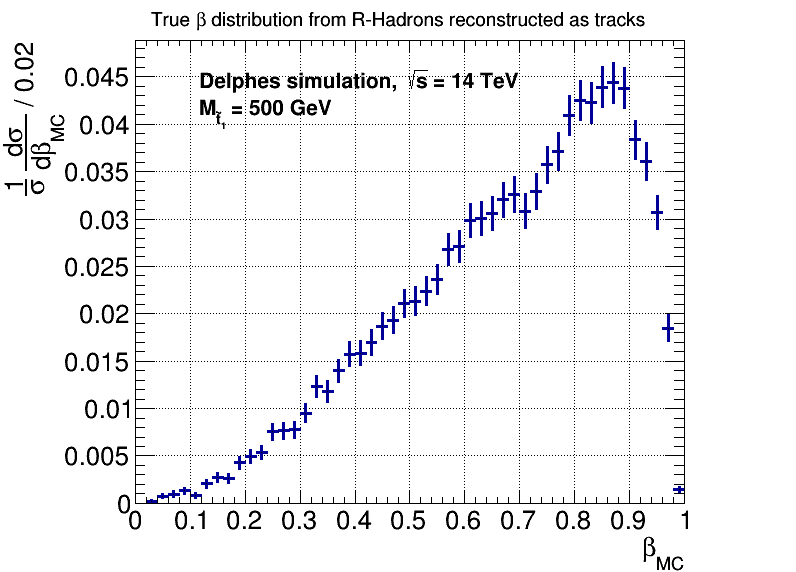

In [23]:
h_beta = rt.TH1F('h_beta','h_beta', 50, 0, 1)
h_beta.Sumw2()
h_beta.SetXTitle('#beta_{MC}')
h_beta.SetYTitle('#frac{1}{#sigma} #frac{d#sigma}{d#beta_{MC}} / '+'{:.2f}'.format(h_beta.GetBinWidth(1)))
h_beta.SetTitle('True #beta distribution from R-Hadrons reconstructed as tracks')
h_beta.SetStats(0)

for b in beta_list:
    h_beta.Fill(b)

h_beta.Scale(1./h_beta.GetEntries())
    
c = rt.TCanvas('c', 'c', 800, 600)
h_beta.Draw()

note = rt.TLatex()
note.SetTextSize(0.04)
note.DrawLatexNDC(0.25, 0.82, '#splitline{Delphes simulation, #sqrt{s} = 14 TeV}{M_{#tilde{t}_{1}} = 500 GeV}')


c.Draw()

In [ ]:
out_idx = np.zeros((numberOfEntries, 4)) - 1

conuter_maxSumPT_vtx = np.zeros((numberOfEntries, 2))

N_tk_genPV = np.zeros(numberOfEntries)

for i in range(int(numberOfEntries*1.)):
    treeReader.ReadEntry(i)
    
    genPV = branch['GenVertex'].At(0)
    
    i_cl = 0
    min_d = 0
    
    i_maxSumPT = 0
    maxSumPT = 0
    
    nv = branch['Vertex4D'].GetEntries()
    if nv == 0:
        print 'No vertexes found in evt', i
        continue
        
    for j in range(nv):
        vtx = branch['Vertex4D'].At(j)
        
        d = (vtx.Z - genPV.Z)/vtx.ErrorZ + (vtx.T - genPV.T)/vtx.ErrorT
        if j == 0 or d < min_d:
            i_cl = j
            min_d = d
            
        if vtx.SumPT > maxSumPT:
            i_maxSumPT = j
            maxSumPT = vtx.SumPT
            
    N_PVtk = np.zeros(nv)
    N_RHadtk = np.zeros(nv)
    for j in range(branch['Track'].GetEntries()):
        track = branch['Track'].At(j)
        p = track.Particle.GetObject()
        if p.IsPU < 0.5:
            N_tk_genPV[i] += 1

        v_idx = int(track.VertexIndex)
        if v_idx >= 0 and p.IsPU < 0.5:
            N_PVtk[v_idx] += 1
            
        if abs(p.PID) > 500000 and v_idx >= 0:
            N_RHadtk[v_idx] += 1
            
        if v_idx == i_maxSumPT:
            if p.IsPU < 0.5:
                conuter_maxSumPT_vtx[i][0] += 1
            else:
                conuter_maxSumPT_vtx[i][1] += 1
            
    if np.sum(N_RHadtk > 0) > 1:
        print i, ': More than one vtx wth RHad'
#         print N_RHadtk
        print '\n'
        
    i_RHad = -2
    if np.sum(N_RHadtk>0) > 0:
        i_RHad = np.argmax(N_RHadtk)
    
    out_idx[i,0] = i_cl
    out_idx[i,1] = i_maxSumPT
    out_idx[i,2] = np.argmax(N_PVtk)
    out_idx[i,3] = i_RHad

In [ ]:
out_idx

In [ ]:
for i in range(4):
    for j in range(i+1,4):
        print i,j, np.sum(out_idx[:,i] == out_idx[:,j])

In [ ]:
np.sum(np.logical_and(out_idx[:,1] == out_idx[:,2], out_idx[:,1] == out_idx[:,3]))

In [ ]:
conuter_maxSumPT_vtx[np.logical_and(out_idx[:,1] == out_idx[:,2], out_idx[:,1] == out_idx[:,3])]

In [ ]:
out = plt.hist(conuter_maxSumPT_vtx[:,0]/(conuter_maxSumPT_vtx[:,0] + conuter_maxSumPT_vtx[:,1]), bins=50)

In [ ]:
out = plt.hist(conuter_maxSumPT_vtx[:,1]/(conuter_maxSumPT_vtx[:,0] + conuter_maxSumPT_vtx[:,1]), bins=50)

In [ ]:
N_tk_genPV

In [ ]:
out = plt.hist(conuter_maxSumPT_vtx[:,0][N_tk_genPV>0]/N_tk_genPV[N_tk_genPV>0], bins=50)

In [ ]:
# for i in range(numberOfEntries):
#     treeReader.ReadEntry(i)
#     nv = branch['Vertex4D'].GetEntries()
    
#     sumpt2_reco = np.zeros(nv)
#     for j in range(nv):
#         sumpt2_reco[j] = branch['Vertex4D'].At(j).SumPT

#     sumpt2_REreco = np.zeros(nv)
#     for j in range(branch['Track'].GetEntries()):
#         track = branch['Track'].At(j)
#         if track.VertexIndex >= 0:
#             sumpt2_REreco[track.VertexIndex] += track.PT
            
#     if np.sum(np.abs(sumpt2_reco - sumpt2_REreco))>1:
#         print "-----  Event", i
#         for j in range(nv):
#             print '{}: {:.1f}  -  {:.1f}'.format(j, sumpt2_REreco[j] , sumpt2_reco[j])

In [ ]:
# gvtx_names = ['Nev','z','t', 'IsPU']
# gvtx_att = []

# rvtx_names = ['Nev','z','t', 'dz', 'dt', 'ndf', 'sumpt2', 'sum_pt', 'N_Rhad', 'max_pt_tk']
# rvtx_att_global = []


# for i in range(numberOfEntries):
#     treeReader.ReadEntry(i)
    
#     for j in range(branch['GenVertex'].GetEntries()):
#         vtx = branch['GenVertex'].At(j)
        
#         p = vtx.Constituents.At(0)
#         ispu = p.IsPU
        
#         gvtx_att.append((i, vtx.Z, vtx.T*1E12, ispu))
    
#     rvtx_att = []
#     for j in range(branch['Vertex4D'].GetEntries()):
#         vtx = branch['Vertex4D'].At(j)
        
#         rvtx_att.append([i, vtx.Z, vtx.T*1E12, vtx.ErrorZ, vtx.ErrorT*1E12, vtx.NDF, 0, 0, 0, 0])
        
#     for j in range(branch['Track'].GetEntries()):
#         track = branch['Track'].At(j)
#         if track.VertexIndex >= 0:
#             k = track.VertexIndex
#             pt = track.PT
#             rvtx_att[k][6] += pt**2
#             rvtx_att[k][7] += pt
            
#             if pt>rvtx_att[k][9]:
#                 rvtx_att[k][9] = pt
            
#             if abs(track.PID)>5000:
#                 rvtx_att[k][8] += 1
                
#     for j in range(len(rvtx_att)):
#         rvtx_att_global.append(rvtx_att[j])
        
# #         np = vtx.Constituents.GetEntriesFast()
# #         for k in range(np):
# #             tr = vtx.Constituents.At(k)
# #             print tr.GetName()
    

# gen_vtx = np.array(gvtx_att, dtype=zip(gvtx_names,['<f8']*len(gvtx_names)))
# reco_vtx = np.array(rvtx_att_global, dtype=zip(rvtx_names,['<f8']*len(rvtx_names)))

# print reco_vtx.shape

Qualche plot per far vedere la qualita dei reco vtx

In [ ]:
# %matplotlib notebook
# N_ev = 15

# plt.figure(figsize=(8,8))

# z_gen = gen_vtx['z'][gen_vtx['Nev'] == N_ev]
# t_gen = gen_vtx['t'][gen_vtx['Nev'] == N_ev]


# z_reco = reco_vtx['z'][reco_vtx['Nev'] == N_ev]
# t_reco = reco_vtx['t'][reco_vtx['Nev'] == N_ev]
# dz_reco = reco_vtx['dz'][reco_vtx['Nev'] == N_ev]
# dt_reco = reco_vtx['dt'][reco_vtx['Nev'] == N_ev]

# # the PV is always the first
# plt.plot(t_gen[0], z_gen[0], 'Dg', label='Gen PV', markersize=7)
# plt.plot(t_gen[1:], z_gen[1:], '*g', label='Gen PU', markersize=5)


# plt.errorbar(t_reco, z_reco, xerr=dt_reco, yerr=dz_reco, fmt='r.', label='Reco Vtx', markersize=7)

# plt.legend(loc='best')
# plt.xlabel(r'$Time$  [ps]')
# plt.ylabel(r'$Z$ [mm]')
# plt.grid()

In [ ]:
# for i in range(numberOfEntries):
#     treeReader.ReadEntry(i)
#     nv = branch['Vertex4D'].GetEntries()
#     sumpt2_reco = np.zeros(nv)
#     for j in range(nv):
#         vtx = branch['Vertex4D'].At(j)
#         sumpt2_reco[j] = vtx.SumPT2
    
#     sumpt2_REreco = np.zeros(nv)
#     for j in range(branch['Track'].GetEntries()):
#         track = branch['Track'].At(j)
#         if track.VertexIndex >= 0:
#             sumpt2_REreco[track.VertexIndex] += track.PT**2
#     if np.sum(np.abs(sumpt2_reco - sumpt2_REreco))>1:
#         print i,':', sumpt2_reco, sumpt2_REreco
#         print i,':', sumpt2_reco - sumpt2_REreco